In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSamplingpling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU, AUC

import warnings
warnings.filterwarnings("ignore")

In [35]:
# DIR = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
DIR='/Users/victoreric/Coding/CNN_Fish_Ambon/dataset'
classes = [i for i in os.listdir(DIR) if '.' not in i]
classes

['Kerapu_Sunu', 'Kerapu_Macan', 'Ikan_Lencam', 'Ikan_Jangki']

In [36]:
label = []
path = []

for dirname, _,filenames in os.walk(DIR):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1]=='.png':              
            if dirname.split()[-1]!='GT':                       
                label.append(os.path.split(dirname)[-1])         
                path.append(os.path.join(dirname,filename))     

df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [37]:
df.head()

,path,label
0,/Users/victoreric/Coding/CNN_Fish_Ambon/datase...,Kerapu_Sunu
1,/Users/victoreric/Coding/CNN_Fish_Ambon/datase...,Kerapu_Sunu
2,/Users/victoreric/Coding/CNN_Fish_Ambon/datase...,Kerapu_Sunu
3,/Users/victoreric/Coding/CNN_Fish_Ambon/datase...,Kerapu_Sunu
4,/Users/victoreric/Coding/CNN_Fish_Ambon/datase...,Kerapu_Sunu


In [38]:
df.path[0]

'/Users/victoreric/Coding/CNN_Fish_Ambon/dataset/Kerapu_Sunu/8.png'

In [39]:
df['label'].value_counts()

label
Kerapu_Sunu     20
Ikan_Lencam     20
Ikan_Jangki     20
Kerapu_Macan    19
Name: count, dtype: int64

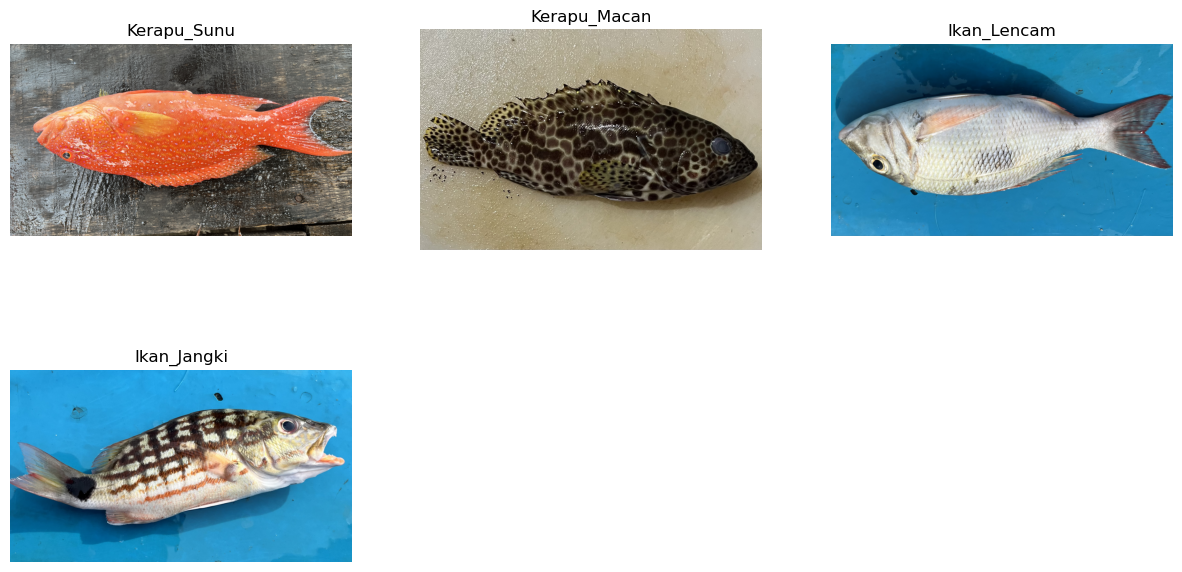

In [40]:
idx = 0
plt.figure(figsize=(15,12))
for unique_label in df['label'].unique():
    plt.subplot(3, 3, idx+1)
    plt.imshow(plt.imread(df[df['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    idx+=1

In [41]:
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

In [42]:
print(train_df.shape)
print(test_df.shape)

(63, 2)
(16, 2)


In [43]:
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='training')
val_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='validation' )
test_images = test_generator.flow_from_dataframe(dataframe=test_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False)

Found 51 validated image filenames belonging to 4 classes.
Found 12 validated image filenames belonging to 4 classes.
Found 16 validated image filenames belonging to 4 classes.


In [44]:
display(train_images.class_indices)
display(val_images.class_indices)
display(test_images.class_indices)

{'Ikan_Jangki': 0, 'Ikan_Lencam': 1, 'Kerapu_Macan': 2, 'Kerapu_Sunu': 3}

{'Ikan_Jangki': 0, 'Ikan_Lencam': 1, 'Kerapu_Macan': 2, 'Kerapu_Sunu': 3}

{'Ikan_Jangki': 0, 'Ikan_Lencam': 1, 'Kerapu_Macan': 2, 'Kerapu_Sunu': 3}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/CNN/lib/python3.8/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


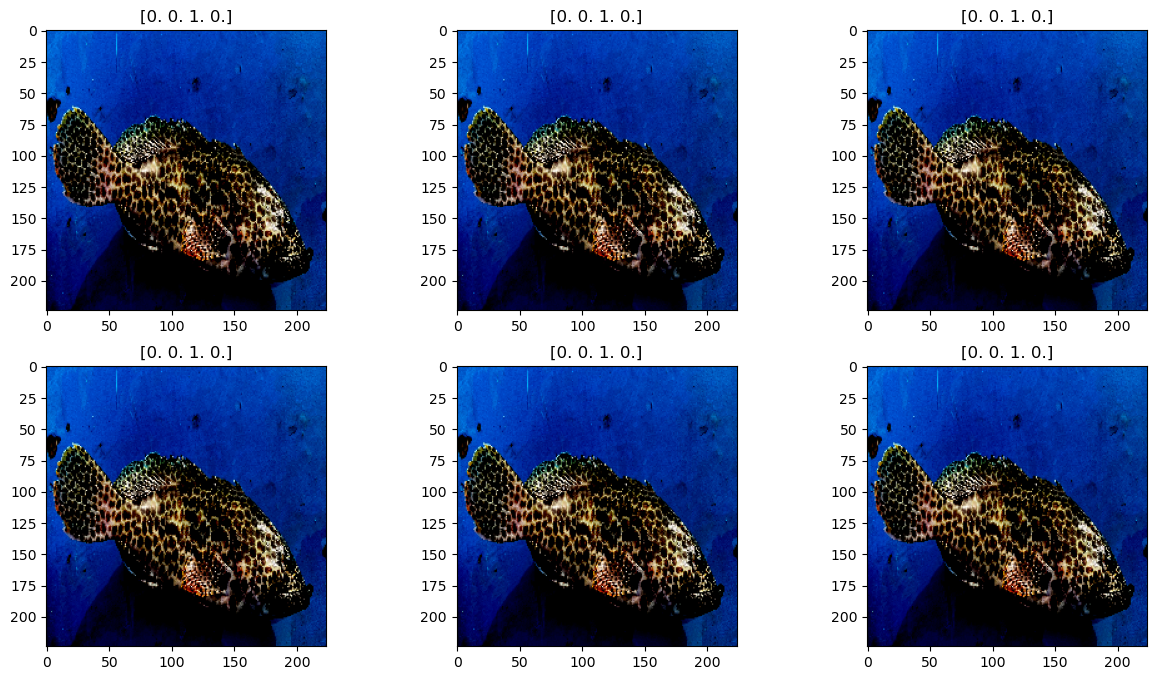

In [45]:
fit, ax= plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax=ax.flatten()
j=0
for _ in range(6):
    img, label = test_images.next()
    ax[j].imshow(img[0],)
    ax[j].set_title(label[0])
    j=j+1

In [50]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [48]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=5)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

2024-08-10 08:47:18.464651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - ETA: 0s - loss: 1.2897 - accuracy: 0.3529 

2024-08-10 08:47:41.681843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 38s 27s/step - loss: 1.2897 - accuracy: 0.3529 - val_loss: 0.6888 - val_accuracy: 1.0000
Epoch 2/5
2/2 [==============================] - 14s 10s/step - loss: 0.5241 - accuracy: 0.9608 - val_loss: 0.3734 - val_accuracy: 1.0000
Epoch 3/5
2/2 [==============================] - 15s 10s/step - loss: 0.1957 - accuracy: 1.0000 - val_loss: 0.1593 - val_accuracy: 1.0000
Epoch 4/5
2/2 [==============================] - 16s 7s/step - loss: 0.0769 - accuracy: 1.0000 - val_loss: 0.0763 - val_accuracy: 1.0000
Epoch 5/5
2/2 [==============================] - 17s 8s/step - loss: 0.0318 - accuracy: 1.0000 - val_loss: 0.0416 - val_accuracy: 1.0000


In [51]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

2024-08-10 08:49:15.153069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Test Loss: 0.02269
Test Accuracy: 100.00%


In [52]:
pred = model.predict(test_images)
pred=np.argmax(pred,axis=1)
pred_df=test_df.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

pred_df=pred_df.reset_index(drop=True)
pred_df.head(10)

2024-08-10 08:49:55.577785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 4s 4s/step


,path,label,pred
0,/Users/victoreric/Coding/CNN_Fish_Ambon/datase...,Kerapu_Macan,Kerapu_Macan
1,/Users/victoreric/Coding/CNN_Fish_Ambon/datase...,Kerapu_Sunu,Kerapu_Sunu
2,/Users/victoreric/Coding/CNN_Fish_Ambon/datase...,Kerapu_Macan,Kerapu_Macan
3,/Users/victoreric/Coding/CNN_Fish_Ambon/datase...,Kerapu_Macan,Kerapu_Macan
4,/Users/victoreric/Coding/CNN_Fish_Ambon/datase...,Kerapu_Sunu,Kerapu_Sunu
5,/Users/victoreric/Coding/CNN_Fish_Ambon/datase...,Kerapu_Macan,Kerapu_Macan
6,/Users/victoreric/Coding/CNN_Fish_Ambon/datase...,Kerapu_Sunu,Kerapu_Sunu
7,/Users/victoreric/Coding/CNN_Fish_Ambon/datase...,Ikan_Jangki,Ikan_Jangki
8,/Users/victoreric/Coding/CNN_Fish_Ambon/datase...,Kerapu_Sunu,Kerapu_Sunu
9,/Users/victoreric/Coding/CNN_Fish_Ambon/datase...,Kerapu_Sunu,Kerapu_Sunu


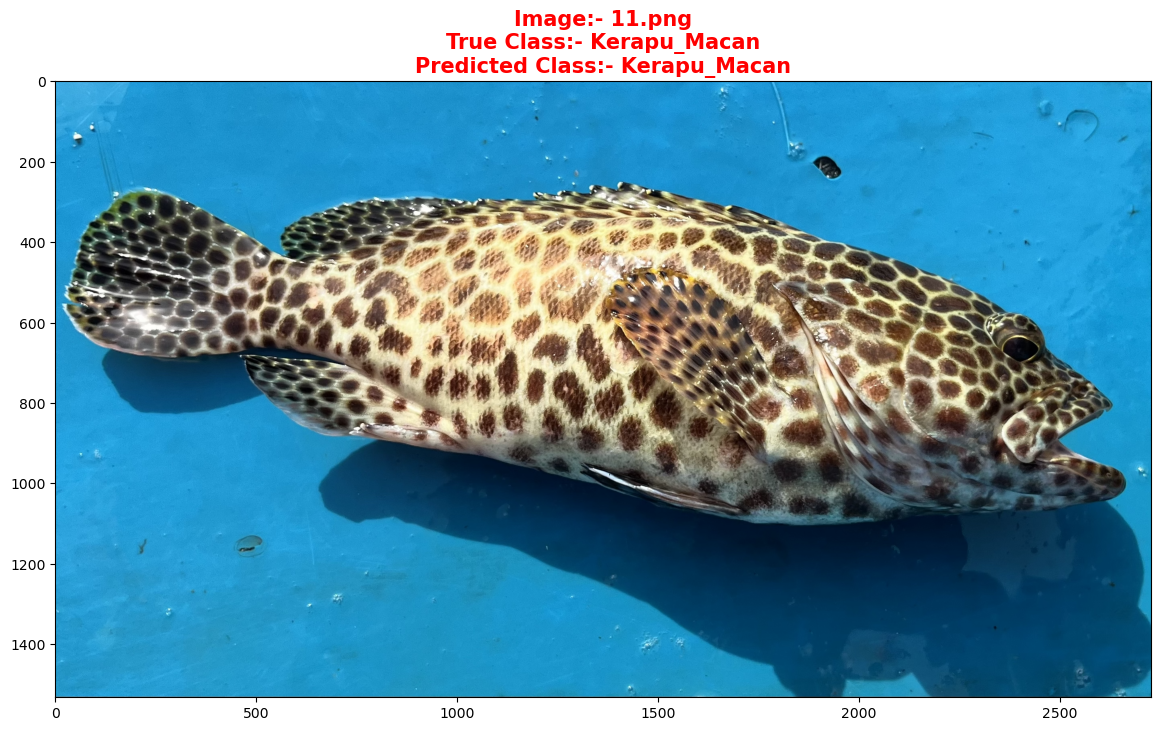

In [60]:
pred_df[pred_df['label']!=pred_df['pred']]

pred_df.path[5]

plt.figure(figsize=(15,8))
plt.imshow(plt.imread(pred_df.path[5]))
title1 = pred_df.path[5].split('/')[-2]
title2 = pred_df.path[5].split('/')[-1]
title3 = pred_df.pred[5]
plt.title(f'Image:- {title2}\nTrue Class:- {title1}\nPredicted Class:- {title3}', color = 'r', weight = 'bold', fontsize = 15)
plt.show()

Accuracy Score: 1.0


<Axes: >

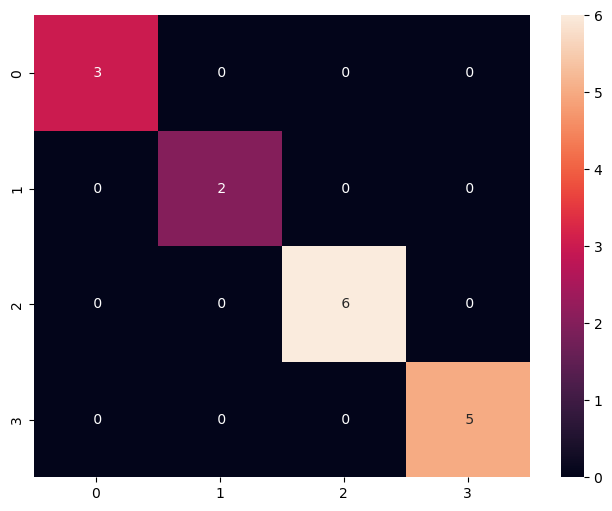

In [55]:
print(f"Accuracy Score: {accuracy_score(pred_df['label'],pred_df['pred'])}")
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(pred_df['label'],pred_df['pred']), annot=True, fmt='2d')

In [56]:
print(classification_report(pred_df['label'],pred_df['pred']))

              precision    recall  f1-score   support

 Ikan_Jangki       1.00      1.00      1.00         3
 Ikan_Lencam       1.00      1.00      1.00         2
Kerapu_Macan       1.00      1.00      1.00         6
 Kerapu_Sunu       1.00      1.00      1.00         5

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

